In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline

# Replication of Runaway Feedback Loop in Predictive Policing (Ensign et al. 2018)

To replicate the paper of Ensign et al. (2018) it is necessary to describe the model.


### "Protagonists" of the model
- One officer
- Two Neighborhoods (A and B)
- A predictive policing model is implemented

### Dynamics of the model
1. Every day the police officer is sent to one of the neighborhoods
2. The Police officer may or may not observe a crime; if they do observe a crime it is logged and we refer to such log as discovered crime
3. Civils may report crimes, we call this logs reported crimes. 
4. The predicitve policing model is recalibrated using the newest feedback (logs)
5. With the new predictions, the officer is given orders about which neighborhood to go in the next period

### Objective of the model

The goal is to create a predictive model for where to send the officer on each day. Specifically, the goal is to distribute the police officers in proportion to the crime in each area. The ideal result is, if $\eta$ % of the crime ocurrs on A, then the $\eta$ % of police resources is allocate to the same neighborhood. 

### Parameters

- $\lambda_A$ : underlying ground truth crime rate for the neighborhood A
- $d_A$ : rate at which the police visits to neighborhood A result in discovered crimes
- $w_d$ : weight of discovered crimes within all crimes
- $w_r$ : weight of reported crimes within all crimes
- $w_d+w_r=1$
- $r_A$ : rate at which incidents are reported from the neighborhood A
- $C_A$ : total rate of crime data from neighborhood A
- $C_A=w_d\cdot d_A+w_r\cdot r_A$


### Assumptions

1. **PREDICTIVE MODEL**: The officer tosses a coin based on current statistics to decide where to go next.
2. **CONTEXT**: The only information retained about crime is a count.
3. **TRUTH IN CRIME DATA**: if an officer goes to a location A with an underlying ground truth crime rate of $\lambda_A$, the oficer discovers crimes at $\lambda_A$ rate ($\lambda_A=d_A$). 
4. **DISCOVERY ONLY** : Crime data is only collected by an officer's presence in a neighborhood. Neighborhoods with no officers will contribute no crimes to the data

# Scenario 1: Uniform crime rates

### Assumptions

- $\lambda_A = \lambda_B = \lambda$
- Only discovered crimes are taken into account, not reported
- Every crime that happened in a neighborhood where an officer is sent is discovered
### Construction of the predictive model (Pólya Urn)

A Pólya urn is going to be use to select the neighborhood where the police is going to be sent. 
- The urn is going to have Red and Black balls. 
- The proportion of Red and Black balls represent the current observed statistics of crime in areas A and B respectively. 
- If a Red ball is pulled from the urn the officer is sent to A.
- If the ball is black he is sent to B.
- Every ball drawned is then replaced in the urn. 
- Observing a crime, which happens with probability $\lambda$, causes a new ball of the same color to be placed in the urn.

#### Defining classes
- Pólya urn

In [2]:
class PolyaUrn:
    def __init__(self,red_b, black_b):
        self.red_b=red_b
        self.black_b=black_b
    def describe(self):
        print('There are {} red balls and {} black balls in this urn'.format(self.red_b, self.black_b))
    def rate_red(self):
        return(self.red_b/(self.red_b+self.black_b))
    def rate_black(self):
        return(self.black_b/(self.red_b+self.black_b))

#### Functions to simulate the model
- *draw_ball* : This function has the objective of drawing a ball of the urn to direct the officer.
- *observed_crime* : This function has the objective of simulating whether a crime is observed or not.
- *update_urn* : This function has the objective of updating a urn.
- *one_t* : This function has the objetive of simulating one period of the model.
- *N_t* : This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.

In [3]:
def draw_ball(urn):
    '''
    This function has the objective of drawing a ball of the urn to direct the officer.
    
    Params: 
    urn: an object class PolyaUrn
    
    Output:
    A character indicating whether the officer is going A or B.
    ''' 
    hood=random.uniform(0,1)<urn.red_b/(urn.red_b+urn.black_b)
    if hood:
        return('A')
    else:
        return('B')

def observed_crime (lambda_p):
    '''
    This function has the objective of simulating whether a crime is observed or not.
    
    Params: 
    lambda_p: the probability of a crime ocurring
    
    Output:
    A boolean indicating whether a crime is observed or not
    ''' 
    if lambda_p>1 or lambda_p<0:
        print('The probability lambda ({}) is outside of the range [0,1]'.format(lambda_p))
    
    observed=random.uniform(0,1)<lambda_p
    return(observed)

def update_urn(urn, hood, crime_observed):
    '''
    This function has the objective of updating a urn.
    
    Params: 
    urn: an object class PolyaUrn
    hood: a character indicating the neighborhood
    crime_observed: a boolean value indicating if the crime was observed
    
    Output:
    The updated urn
    ''' 
    if crime_observed:
        if hood=='A':
            urn.red_b=urn.red_b+1
        else:
            urn.black_b=urn.black_b+1
        return(urn)
    else:
        return(urn)
    
    
def one_t (urn, lambda_uni, verbose=False):
    '''
    This function has the objetive of simulating one period of the model.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    
    Output:
    An updated urn after a period
    ''' 
    
    hood=draw_ball(urn)
    bool_crime=observed_crime(lambda_uni)
    if verbose:
        if bool_crime:
            verb='did'
        else:
            verb="didn't"
        print('The officer was sent to the neighborhood {}, and he {} observe a crime'.format(hood, verb))
    urn_updated=update_urn(urn, hood, crime_observed=bool_crime)
        
    
    return(urn_updated)

def N_t(urn, lambda_uni, N, verbose=False):
    '''
    This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    N: the number of periods 
    
    Output:
    An updated urn after a period
    ''' 
    history_red=[]
    history_black=[]
    history_red_rate=[]
    for i in range(0, N):
        urn=one_t(urn, lambda_uni, verbose=False)
        history_red.append(urn.red_b)
        history_black.append(urn.black_b)
        history_red_rate.append(urn.rate_red())
        if verbose:
            if N<=1000:
                if i%100==0:
                    print('Period: {}'.format(i))
            elif N<=10000:
                if i%1000==0:
                    print('Period: {}'.format(i))
            else:
                if i%10000==0:
                    print('Period: {}'.format(i))

    return history_red, history_black, history_red_rate

#### Defining hyperparameters and the Pólya-Urn

In [4]:
lambda_uni=0.3 # probability of crime ocurring on either neighborhood
red_balls=700 # The starting Red balls, current observed crimes in A
black_balls=200 # The starting Black balls, current observed crimes in B
N=100000 #Numer of periods
urn=PolyaUrn(red_b=red_balls, black_b=black_balls) # definition of the urn

In [5]:
## Run the model N times
red, black, red_rate=N_t(urn, lambda_uni, N, False)

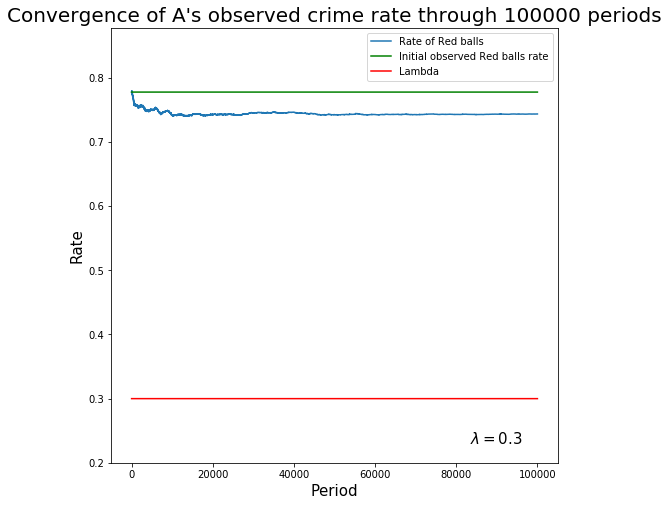

In [6]:
##Plot results
plt.figure(figsize=(8, 8))
plt.plot(list(range(0,N)), red_rate)
plt.plot(list(range(0,N)), [red_balls/(red_balls+black_balls)]*N, color='green')
plt.plot(list(range(0,N)), [lambda_uni]*N, color='red')
plt.ylim([min([lambda_uni-0.1,red_balls/(red_balls+black_balls)-0.1]),max([lambda_uni+0.1,red_balls/(red_balls+black_balls)+0.1])])
plt.title("Convergence of A's observed crime rate through {} periods". format(N), fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('Rate',fontsize=15)
plt.text(y=min([lambda_uni-0.07,red_balls/(red_balls+black_balls)-0.07]), x=N-N/6, s='$\lambda ={}$'.format(lambda_uni), fontsize=15)
plt.legend(('Rate of Red balls', 'Initial observed Red balls rate', 'Lambda'));

# Scenario 2: Non-Uniform crime rates

### Assumptions

- $\lambda_A \neq \lambda_B$
- Only discovered crimes are taken into account, not reported
- Every crime that happened in a neighborhood where an officer is sent is discovered

### Construction of the predictive model (Non-Standard Pólya Urn)
- $n_A^{(t)}$ and $n_B^{(t)}$ are the number of balls corresponding to each neighborhood on the period $t$.
- The overall probability of adding any ball in $t$ is: $\frac{n_A^{(t)}\lambda_A + n_B^{(t)}\lambda_B}{n_A^{(t)} + n_B^{(t)}}$ (weighted mean of the $\lambda$s).
- The probability of adding a ball color A, _conditioned on adding some ball_ is given by: $\frac{Pr(\text{adding A-colored ball})}{Pr(\text{adding any ball})}=\frac{n_A^{(t)}\lambda_A}{n_A^{(t)} + n_B^{(t)}}$

#### Defining classes
- Pólya urn

In [7]:
class PolyaUrn:
    def __init__(self,red_b, black_b, lambda_A, lambda_B):
        self.red_b=red_b
        self.black_b=black_b
        self.lambda_A=lambda_A
        self.lambda_B=lambda_B
    def describe(self):
        print('There are {} red balls and {} black balls in this urn'.format(self.red_b, self.black_b))
    def rate_red(self):
        return(self.red_b/(self.red_b+self.black_b))
    def rate_black(self):
        return(self.black_b/(self.red_b+self.black_b))
    def prob_of_adding(self):
        return((self.red_b*self.lambda_A+self.black_b+self.lambda_B)/(self.red_b+self.black_b))

#### Functions to simulate the model
- *draw_ball* : This function has the objective of drawing a ball of the urn to direct the officer.
- *observed_crime* : This function has the objective of simulating whether a crime is observed or not.
- *update_urn* : This function has the objective of updating a urn.
- *one_t* : This function has the objetive of simulating one period of the model.
- *N_t* : This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.

In [8]:
def draw_ball(urn):
    '''
    This function has the objective of drawing a ball of the urn to direct the officer.
    
    Params: 
    urn: an object class PolyaUrn
    
    Output:
    A character indicating whether the officer is going A or B.
    ''' 
    hood=random.uniform(0,1)<urn.red_b/(urn.red_b+urn.black_b)
    if hood:
        return('A')
    else:
        return('B')

def observed_crime (urn, hood):
    '''
    This function has the objective of simulating whether a crime is observed or not.
    
    Params: 
    lambda_p: the probability of a crime ocurring
    
    Output:
    A boolean indicating whether a crime is observed or not
    ''' 
    if hood=='A':
        lambda_p=urn.lambda_A
    else:
        lambda_p=urn.lambda_B
    if lambda_p>1 or lambda_p<0:
        print('The probability lambda ({}) is outside of the range [0,1]'.format(lambda_p))
    
    observed=random.uniform(0,1)<lambda_p
    return(observed)

def update_urn(urn, hood, crime_observed):
    '''
    This function has the objective of updating a urn.
    
    Params: 
    urn: an object class PolyaUrn
    hood: a character indicating the neighborhood
    crime_observed: a boolean value indicating if the crime was observed
    
    Output:
    The updated urn
    ''' 
    if crime_observed:
        if hood=='A':
            urn.red_b=urn.red_b+1
        else:
            urn.black_b=urn.black_b+1
        return(urn)
    else:
        return(urn)
    
    
def one_t (urn, verbose=False):
    '''
    This function has the objetive of simulating one period of the model.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    
    Output:
    An updated urn after a period
    ''' 
    
    hood=draw_ball(urn)
    bool_crime=observed_crime(urn, hood)
    if verbose:
        if bool_crime:
            verb='did'
        else:
            verb="didn't"
        print('The officer was sent to the neighborhood {}, and he {} observe a crime'.format(hood, verb))
    urn_updated=update_urn(urn, hood, crime_observed=bool_crime)
        
    
    return(urn_updated)

def N_t(urn, N, verbose=False):
    '''
    This function has the objetive of simulating N periods of the model and saving the history of logs of Red and Black balls and the Red Rate.
    
    Params: 
    urn: an object class PolyaUrn
    lambda_uni: the probability of a crime ocurring
    N: the number of periods 
    
    Output:
    An updated urn after a period
    ''' 
    history_red=[]
    history_black=[]
    history_red_rate=[]
    for i in range(0, N):
        urn=one_t(urn, verbose=False)
        history_red.append(urn.red_b)
        history_black.append(urn.black_b)
        history_red_rate.append(urn.rate_red())
        if verbose:
            if N<=1000:
                if i%100==0:
                    print('Period: {}'.format(i))
            elif N<=10000:
                if i%1000==0:
                    print('Period: {}'.format(i))
            else:
                if i%10000==0:
                    print('Period: {}'.format(i))

    return history_red, history_black, history_red_rate

### Case 1: $\lambda_A<\lambda_B$

#### Defining hyperparameters and the Pólya-Urn

In [9]:
lambda_A=0.1 # probability of crime ocurring in the neighborhood A
lambda_B=0.2 # probability of crime ocurring in the neighborhood B
red_balls=100 # The starting Red balls, current observed crimes in A
black_balls=200 # The starting Black balls, current observed crimes in B
N=1000000 #Numer of periods
urn=PolyaUrn(red_b=red_balls, black_b=black_balls, lambda_A=lambda_A, lambda_B=lambda_B) # definition of the urn

In [10]:
%%time
## Run the model N times
red, black, red_rate=N_t(urn, N, False)

Wall time: 3.23 s


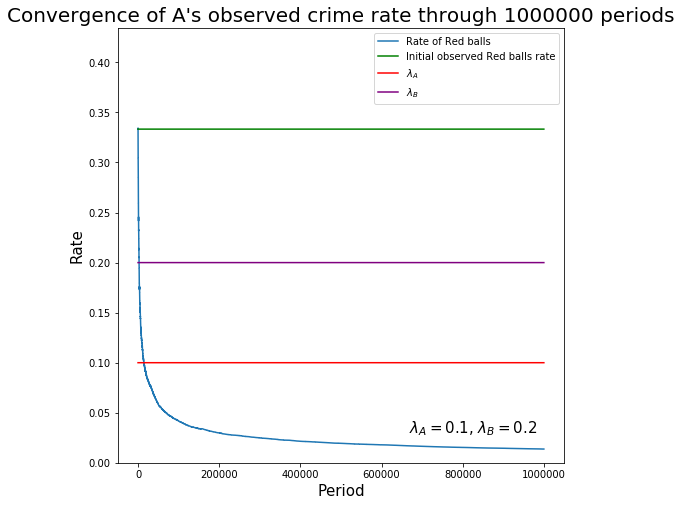

In [11]:
##Plot results
plt.figure(figsize=(8, 8))
plt.plot(list(range(0,N)), red_rate)
plt.plot(list(range(0,N)), [red_balls/(red_balls+black_balls)]*N, color='green')
plt.plot(list(range(0,N)), [urn.lambda_A]*N, color='red')
plt.plot(list(range(0,N)), [urn.lambda_B]*N, color='purple')
plt.ylim([min([urn.lambda_A-0.1,red_balls/(red_balls+black_balls)-0.1]), max([urn.lambda_A+0.1,red_balls/(red_balls+black_balls)+0.1, max(red_rate)+0.1]) ])
plt.title("Convergence of A's observed crime rate through {} periods". format(N), fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('Rate',fontsize=15)
plt.text(y=min([urn.lambda_A-0.07,red_balls/(red_balls+black_balls)-0.07]), x=N-N/3, s='$\lambda_A ={}$, $\lambda_B ={}$ '.format(urn.lambda_A, urn.lambda_B), fontsize=15)
plt.legend(('Rate of Red balls', 'Initial observed Red balls rate', '$\lambda_A$', '$\lambda_B$'));

### Case 2: $\lambda_B<\lambda_A$

#### Defining hyperparameters and the Pólya-Urn

In [12]:
lambda_A=0.3 # probability of crime ocurring in the neighborhood A
lambda_B=0.2 # probability of crime ocurring in the neighborhood B
red_balls=100 # The starting Red balls, current observed crimes in A
black_balls=200 # The starting Black balls, current observed crimes in B
N=1000000 #Numer of periods
urn=PolyaUrn(red_b=red_balls, black_b=black_balls, lambda_A=lambda_A, lambda_B=lambda_B) # definition of the urn

In [13]:
%%time
## Run the model N times
red, black, red_rate=N_t(urn, N, False)

Wall time: 3.56 s


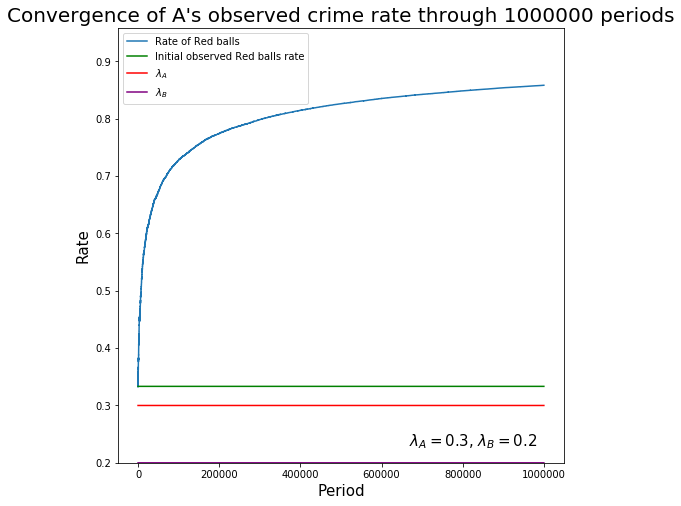

In [14]:
##Plot results
plt.figure(figsize=(8, 8))
plt.plot(list(range(0,N)), red_rate)
plt.plot(list(range(0,N)), [red_balls/(red_balls+black_balls)]*N, color='green')
plt.plot(list(range(0,N)), [urn.lambda_A]*N, color='red')
plt.plot(list(range(0,N)), [urn.lambda_B]*N, color='purple')
plt.ylim([min([urn.lambda_A-0.1,red_balls/(red_balls+black_balls)-0.1]), max([urn.lambda_A+0.1,red_balls/(red_balls+black_balls)+0.1, max(red_rate)+0.1]) ])
plt.title("Convergence of A's observed crime rate through {} periods". format(N), fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('Rate',fontsize=15)
plt.text(y=min([urn.lambda_A-0.07,red_balls/(red_balls+black_balls)-0.07]), x=N-N/3, s='$\lambda_A ={}$, $\lambda_B ={}$ '.format(urn.lambda_A, urn.lambda_B), fontsize=15)
plt.legend(('Rate of Red balls', 'Initial observed Red balls rate', '$\lambda_A$', '$\lambda_B$'));